In [1]:
# Initial setup cell
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (VGG16, ResNet50, EfficientNetB0)  # Common transfer learning models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


In [2]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# 1. Use absolute paths with pathlib (recommended)
project_root = Path("/Users/mohdshahbaaz/Desktop/MLProject/minor/minor")  # UPDATE THIS
data_dir = project_root / "datasets"

# 2. Define paths - use your actual folder names
train_dir = data_dir / "training"  # Changed from 'train' to 'training'
val_dir = data_dir / "validation"
test_dir = data_dir / "testing"     # Changed from 'test' to 'testing'

# 3. Verify paths exist
print("Verifying paths...")
print(f"Project root: {project_root.exists()}")
print(f"Data directory: {data_dir.exists()}")
print(f"Train directory: {train_dir.exists()} ({len(list(train_dir.glob('*')))} subfolders)")
print(f"Validation directory: {val_dir.exists()}")
print(f"Test directory: {test_dir.exists()}")

# 4. Check folder contents
def check_folder_structure():
    print("\nFolder structure verification:")
    for split in [train_dir, val_dir, test_dir]:
        print(f"\n{split.name}:")
        if split.exists():
            for class_name in ['real', 'fake']:  # Using your actual folder names
                class_path = split / class_name
                print(f"  {class_name}: ", end="")
                if class_path.exists():
                    num_images = len(list(class_path.glob('*.*')))
                    print(f"{num_images} images")
                else:
                    print("MISSING")
        else:
            print("  Directory not found")

check_folder_structure()

Verifying paths...
Project root: True
Data directory: True
Train directory: True (4 subfolders)
Validation directory: True
Test directory: True

Folder structure verification:

training:
  real: 1388 images
  fake: 1388 images

validation:
  real: 296 images
  fake: 296 images

testing:
  real: 297 images
  fake: 298 images


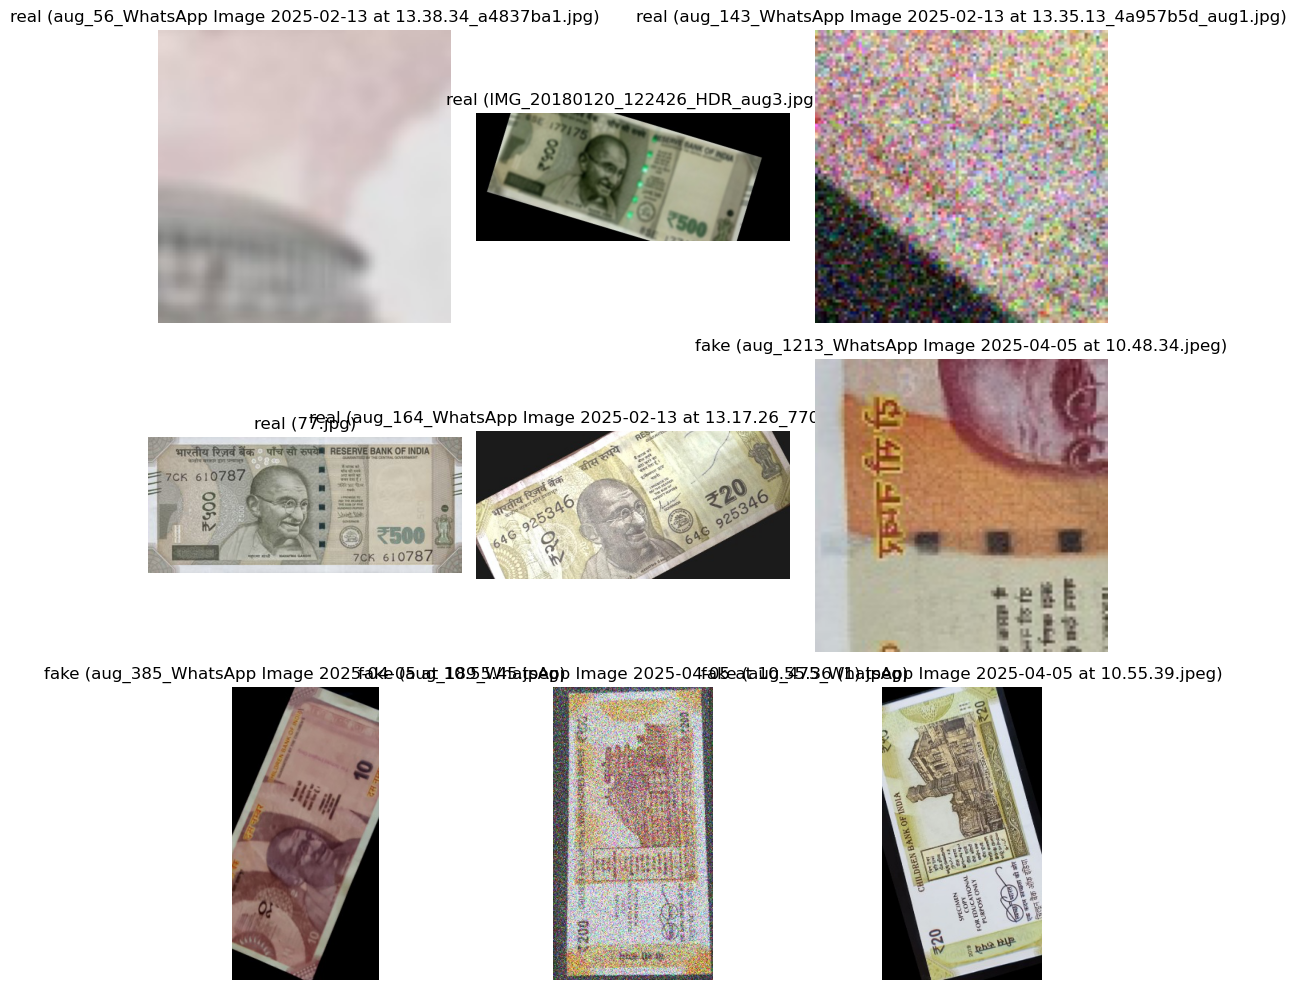

In [3]:
def plot_sample_images():
    plt.figure(figsize=(10, 10))
    images_shown = 0
    
    # Loop through both classes
    for class_idx, class_name in enumerate(['real', 'fake']):  # Your actual folder names
        class_path = train_dir / class_name
        
        if not class_path.exists():
            print(f"Warning: {class_path} not found")
            continue
            
        # Get first 4-5 images from each class
        image_files = list(class_path.glob('*.*'))[:5]
        
        for i, img_path in enumerate(image_files):
            if images_shown >= 9:
                break
                
            plt.subplot(3, 3, images_shown + 1)
            try:
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f"{class_name} ({img_path.name})")
                plt.axis("off")
                images_shown += 1
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if images_shown == 0:
        print("No images found in:", train_dir)
    else:
        plt.tight_layout()
        plt.show()

plot_sample_images()

In [4]:
print("Current working directory:", os.getcwd())
# If wrong, change it:
os.chdir("/Users/mohdshahbaaz/Desktop/MLProject/minor/minor")

Current working directory: /Users/mohdshahbaaz/Desktop/MLProject/minor


In [5]:
import os
print(f"Readable: {os.access(train_dir, os.R_OK)}")
print(f"Executable: {os.access(train_dir, os.X_OK)}")

Readable: True
Executable: True


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using your actual folder names
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['real', 'fake']  # Your actual class folders
)

print("\nFound classes:", train_generator.class_indices)

Found 2783 images belonging to 2 classes.

Found classes: {'real': 0, 'fake': 1}


In [7]:
# Image dimensions
img_height, img_width = 224, 224  # Standard size for many transfer learning models
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should not be augmented
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # or 'categorical' if you have more classes
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

Found 2783 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
Found 597 images belonging to 3 classes.


In [8]:
# Choose a base model (you can experiment with different ones)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model
base_model.trainable = False

# Build the model
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('beeest_model.h5', save_best_only=True)
]

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

/Users/mohdshahbaaz/Desktop/MLProject/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.4931 - loss: -15.3319

87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 315ms/step - accuracy: 0.4931 - loss: -15.5945 - val_accuracy: 0.5000 - val_loss: -105.3898
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5023 - loss: -160.9645

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.5023 - loss: -161.7349 - val_accuracy: 0.5000 - val_loss: -399.0509
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5117 - loss: -491.9375

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5116 - loss: -493.3937 - val_accuracy: 0.5000 - val_loss: -902.7531
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.4979 - loss: -1056.6962

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.4979 - loss: -1058.5818 - val_accuracy: 0.5000 - val_loss: -1620.8168
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.4907 - loss: -1842.7856

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.4908 - loss: -1844.8477 - val_accuracy: 0.5000 - val_loss: -2551.7266
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5085 - loss: -2735.1729

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5084 - loss: -2738.6992 - val_accuracy: 0.5000 - val_loss: -3681.6372
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4952 - loss: -3983.8403

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.4953 - loss: -3986.8975 - val_accuracy: 0.5000 - val_loss: -5018.8350
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4889 - loss: -5452.9761

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.4890 - loss: -5455.5640 - val_accuracy: 0.5000 - val_loss: -6571.3560
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5020 - loss: -6819.7129

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.5020 - loss: -6824.6836 - val_accuracy: 0.5000 - val_loss: -8286.0674
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5092 - loss: -8455.8262

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.5091 - loss: -8462.3984 - val_accuracy: 0.5000 - val_loss: -10187.8330
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5221 - loss: -10011.4746

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.5218 - loss: -10022.1758 - val_accuracy: 0.5000 - val_loss: -12263.3545
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4859 - loss: -12939.2070

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - accuracy: 0.4861 - loss: -12941.8037 - val_accuracy: 0.5000 - val_loss: -14517.0781
Epoch 13/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.4835 - loss: -15312.6455

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.4837 - loss: -15313.4395 - val_accuracy: 0.5000 - val_loss: -16931.0840
Epoch 14/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4936 - loss: -17575.9316

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.4937 - loss: -17579.8633 - val_accuracy: 0.5000 - val_loss: -19505.6777
Epoch 15/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5012 - loss: -19785.9062

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5012 - loss: -19793.5195 - val_accuracy: 0.5000 - val_loss: -22222.1426
Epoch 16/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4830 - loss: -23174.2227

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.4832 - loss: -23173.9551 - val_accuracy: 0.5000 - val_loss: -25112.1055
Epoch 17/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5197 - loss: -24411.9805

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5194 - loss: -24431.9258 - val_accuracy: 0.5000 - val_loss: -28131.0430
Epoch 18/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5077 - loss: -27957.0215

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - accuracy: 0.5076 - loss: -27971.7168 - val_accuracy: 0.5000 - val_loss: -31329.9316
Epoch 19/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4943 - loss: -32023.9277

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - accuracy: 0.4944 - loss: -32028.4688 - val_accuracy: 0.5000 - val_loss: -34691.5352
Epoch 20/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4915 - loss: -35601.6562

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.4916 - loss: -35603.2578 - val_accuracy: 0.5000 - val_loss: -38194.5430


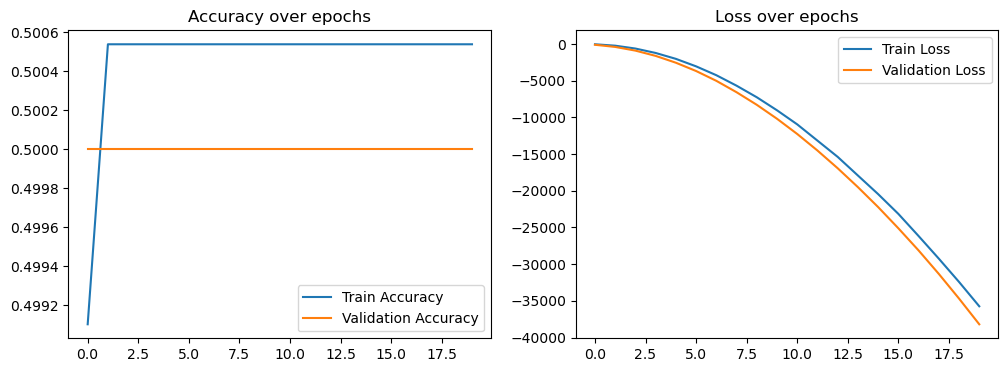

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.8125 - loss: -14331.2959
Test accuracy: 0.5025
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step


NameError: name 'class_names' is not defined

<Figure size 600x600 with 0 Axes>

In [10]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()
    
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))




# Plot training history
# def plot_history(history):
#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Accuracy over epochs')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Loss over epochs')
#     plt.legend()
    
#     plt.show()

# plot_history(history)

# # Evaluate on test set
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test accuracy: {test_acc:.4f}")

# # Generate predictions
# predictions = model.predict(test_generator)
# predicted_classes = (predictions > 0.5).astype("int32")

# # Define class_names before using them
# # You need to replace this with your actual class names
# class_names = ['class0', 'class1']  # Replace with your actual class names

# # Confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report

# true_classes = test_generator.classes
# cm = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# # Classification report
# print(classification_report(true_classes, predicted_classes, target_names=class_names))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,004,445 (15.28 MB)

 Non-trainable params: 209,223 (817.28 KB)

Epoch 20/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 579ms/step - accuracy: 0.0558 - loss: -293.4961 - val_accuracy: 0.5000 - val_loss: -23658.5293
Epoch 21/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 50s 579ms/step - accuracy: 0.1350 - loss: -5032.5405 - val_accuracy: 0.5000 - val_loss: -24004.4980
Epoch 22/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 587ms/step - accuracy: 0.2901 - loss: -13980.7861 - val_accuracy: 0.5000 - val_loss: -25466.8438
Epoch 23/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.4170 - loss: -26399.3711 - val_accuracy: 0.5000 - val_loss: -34933.1641
Epoch 24/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4869 - loss: -38770.8867

87/87 ━━━━━━━━━━━━━━━━━━━━ 52s 596ms/step - accuracy: 0.4869 - loss: -38794.5938 - val_accuracy: 0.5000 - val_loss: -43350.5859
Epoch 25/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.4875 - loss: -47373.6133

87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 604ms/step - accuracy: 0.4877 - loss: -47367.7344 - val_accuracy: 0.5000 - val_loss: -49882.9492
Epoch 26/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.4966 - loss: -49989.8242

87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 628ms/step - accuracy: 0.4966 - loss: -49995.6172 - val_accuracy: 0.5000 - val_loss: -53396.1875
Epoch 27/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4954 - loss: -51110.7305

87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 614ms/step - accuracy: 0.4955 - loss: -51121.8750 - val_accuracy: 0.5000 - val_loss: -54896.7461
Epoch 28/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.5027 - loss: -54846.4766

87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 587ms/step - accuracy: 0.5027 - loss: -54855.7188 - val_accuracy: 0.5000 - val_loss: -57514.9648
Epoch 29/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 586ms/step - accuracy: 0.4984 - loss: -57770.9102 - val_accuracy: 0.5000 - val_loss: -57169.3906
Epoch 30/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 585ms/step - accuracy: 0.4890 - loss: -59668.6445 - val_accuracy: 0.5000 - val_loss: -56900.6680


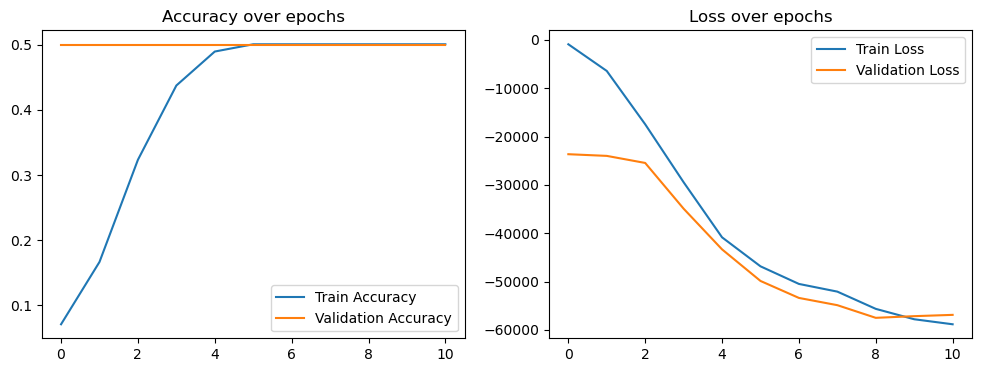

In [11]:
# Unfreeze the top N layers while keeping BatchNorm layers frozen
base_model.trainable = True
fine_tune_at = 100  # Number of layers to unfreeze

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # Freeze early layers
    
# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Continue training
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=callbacks
)

# Plot the fine-tuning results
plot_history(history_fine)

In [12]:
# VGG16 Model
base_model_vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model_vgg.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model_vgg(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_vgg = keras.Model(inputs, outputs)

model_vgg.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_vgg = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4914 - loss: -9.7091 - val_accuracy: 0.5000 - val_loss: -63.5596
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5075 - loss: -93.3885 - val_accuracy: 0.5000 - val_loss: -249.2299
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5022 - loss: -302.6355 - val_accuracy: 0.5000 - val_loss: -571.5466
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5075 - loss: -628.1375 - val_accuracy: 0.5000 - val_loss: -1026.8547
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4836 - loss: -1143.7620 - val_accuracy: 0.5000 - val_loss: -1618.2338
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5074 - loss: -1652.6012 - val_accuracy: 0.5000 - val_loss: -2340.6663
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5027 - loss: -2391.8589 - val_accuracy: 0.5000 - val_loss: -3199.4482
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5

In [13]:
# ResNet50 Model
base_model_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model_resnet.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model_resnet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_resnet = keras.Model(inputs, outputs)

model_resnet.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_resnet = model_resnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 681ms/step - accuracy: 0.4861 - loss: -25.8092 - val_accuracy: 0.5000 - val_loss: -170.5757
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 674ms/step - accuracy: 0.5019 - loss: -270.8220 - val_accuracy: 0.5000 - val_loss: -688.9564
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 671ms/step - accuracy: 0.5212 - loss: -846.3617 - val_accuracy: 0.5000 - val_loss: -1605.8853
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 669ms/step - accuracy: 0.5088 - loss: -1867.9847 - val_accuracy: 0.5000 - val_loss: -2910.3411
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 674ms/step - accuracy: 0.4967 - loss: -3280.3003 - val_accuracy: 0.5000 - val_loss: -4574.7153
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 677ms/step - accuracy: 0.4915 - loss: -5141.0640 - val_accuracy: 0.5000 - val_loss: -6599.0674
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 677ms/step - accuracy: 0.5007 - loss: -7142.6982 - val_accuracy: 0.5000 - val_loss: -8988.5752
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 678ms

In [17]:
model.save('/Users/mohdshahbaaz/Desktop/MLProject/minor/fake_currency_detector.h5')


In [16]:
import os
print(os.getcwd()) 

/Users/mohdshahbaaz/Desktop/MLProject/minor/minor


In [20]:
# from tensorflow.keras.models import load_model
# # Load the saved model
# loaded_model = load_model('/Users/mohdshahbaaz/Desktop/MLProject/minor/fake_currency_detector.h5')

In [28]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets  # <-- Correct import

# Load the saved model
model = load_model('/Users/mohdshahbaaz/Desktop/MLProject/minor/fake_currency_detector.h5')

def process_image(file_path):
    # Load and preprocess the image
    img = image.load_img(file_path, target_size=(224, 224))  # Match model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    if prediction[0][0] > 0.5:
        print(f"Result: REAL currency (confidence: {prediction[0][0]:.2f})")
    else:
        print(f"Result: FAKE currency (confidence: {1 - prediction[0][0]:.2f})")
    
    return prediction

def handle_upload(change):
    import os
    import tempfile
    
    # Get uploaded file content
    for filename, file_info in uploader.value.items():
        with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as f:
            f.write(file_info['content'])
            temp_path = f.name

        process_image(temp_path)
        os.unlink(temp_path)

# Create upload button (Jupyter Notebook only)
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(handle_upload, names='value')
display(uploader)


FileUpload(value=(), accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


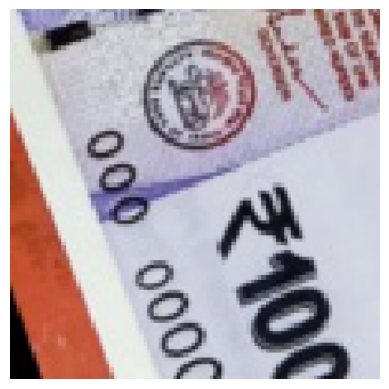

Result: REAL currency (confidence: 1.00)


array([[1.]], dtype=float32)

In [30]:
process_image('/Users/mohdshahbaaz/Desktop/MLProject/minor/minor/datasets/testing/fake/aug_1388_WhatsApp Image 2025-04-05 at 10.59.15.jpeg')

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # 1. Enhanced Data Augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Adjust batch size if needed
# batch_size = 32

# # Update your data generators with the new augmentation settings
# train_generator = train_datagen.flow_from_directory(
#     'path/to/train/data',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='binary'  # or 'categorical' for multi-class
# )

# validation_generator = validation_datagen.flow_from_directory(
#     'path/to/validation/data',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='binary'  # or 'categorical' for multi-class
# )

# test_generator = test_datagen.flow_from_directory(
#     'path/to/test/data',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='binary',  # or 'categorical' for multi-class
#     shuffle=False  # Important for evaluation
# )

# # 2. Transfer Learning with a pre-trained model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# # 3. Create a more robust model architecture
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
# x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)
# predictions = Dense(1, activation='sigmoid')(x)  # For binary classification

# model = Model(inputs=base_model.input, outputs=predictions)

# # 4. Use a better optimizer with a carefully chosen learning rate
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # 5. Implement callbacks for better training
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# checkpoint = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# # 6. Train the model with the callbacks
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=50,  # Start with more epochs, early stopping will prevent overfitting
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )

# # 7. Fine-tuning: unfreeze some layers of the base model and train with a very small learning rate
# # After initial training completes, uncomment and run this section
# '''
# for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
#     layer.trainable = True

# model.compile(
#     optimizer=Adam(learning_rate=1e-5),  # Use a smaller learning rate for fine-tuning
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# history_fine_tuning = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=30,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )
# '''

# # 8. Evaluate the model
# model.load_weights('best_model.h5')  # Load the best model saved during training
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test accuracy: {test_acc:.4f}")

# # Get class names for reporting
# class_names = list(train_generator.class_indices.keys())

# # Generate predictions
# predictions = model.predict(test_generator)
# predicted_classes = (predictions > 0.5).astype("int32")

# # Confusion matrix and classification report
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns

# true_classes = test_generator.classes
# cm = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report

# # Define paths for your dataset structure
# train_dir = 'minor/dataset/training'
# validation_dir = 'minor/dataset/validation'
# test_dir = 'minor/dataset/testing'

# # Define image parameters
# img_height, img_width = 224, 224  # Standard size for many pre-trained models
# batch_size = 32  # Adjust based on your memory constraints

# # Class names
# class_names = ['real', 'fake']  # Your binary classes

# # 1. Enhanced Data Augmentation - especially important with only ~1400 images
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],  # Add brightness variation
#     fill_mode='nearest'
# )

# # Only rescale validation and test data
# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Create data generators
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',  # Binary classification (real vs fake)
#     shuffle=True
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     shuffle=False
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     shuffle=False
# )

# # 2. Transfer Learning with a pre-trained model
# # For a smaller dataset (~1400 images), MobileNetV2 is a good choice
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# # Freeze the base model layers initially
# for layer in base_model.layers:
#     layer.trainable = False

# # 3. Create a model architecture suitable for binary classification with a small dataset
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)  # Higher dropout for small dataset to prevent overfitting
# x = BatchNormalization()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# model = Model(inputs=base_model.input, outputs=predictions)

# # 4. Use a conservative learning rate for small dataset
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # 5. Implement callbacks
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# # Save model to the current directory
# checkpoint = ModelCheckpoint(
#     'best_real_fake_model.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# # 6. Train the model - with a smaller dataset, we might need more epochs
# print("Starting initial training phase...")
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size + 1,
#     epochs=30,  # Start with more epochs, early stopping will prevent overfitting
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size + 1,
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )

# # 7. Fine-tuning: unfreeze some layers of the base model and train with a very small learning rate
# print("Starting fine-tuning phase...")
# # Unfreeze the top layers of the model
# for layer in base_model.layers[-15:]:  # Unfreeze fewer layers for a small dataset
#     layer.trainable = True

# model.compile(
#     optimizer=Adam(learning_rate=1e-5),  # Very small learning rate for fine-tuning
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# history_fine_tuning = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size + 1,
#     epochs=20,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size + 1,
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )

# # 8. Evaluate the model
# print("Loading best model weights...")
# model.load_weights('best_real_fake_model.h5')  # Load the best model saved during training
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test accuracy: {test_acc:.4f}")

# # 9. Plot training history
# def plot_history(history):
#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Accuracy over epochs')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Loss over epochs')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# print("Plotting training history...")
# plot_history(history)
# if 'history_fine_tuning' in locals():
#     print("Plotting fine-tuning history...")
#     plot_history(history_fine_tuning)

# # 10. Generate predictions and evaluation metrics
# print("Generating predictions and evaluation metrics...")
# predictions = model.predict(test_generator)
# predicted_classes = (predictions > 0.5).astype("int32")

# # Confusion matrix
# true_classes = test_generator.classes
# cm = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()

# # Classification report
# print("\nClassification Report:")
# print(classification_report(true_classes, predicted_classes, target_names=class_names))

# # 11. Save some example predictions for visual inspection
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing import image

# def load_and_preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(img_height, img_width))